# Libraries and Data

In [455]:
# Import Libraries
import copy
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm, skew

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler

%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [456]:
# Import Dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Data Preparation
### 1. Exploration

In [457]:
# Review Data Structure
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [458]:
train.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1452,1452.000000,1460,1460,1460,1423,1423,1422,1423,1460.000000,1422,1460.000000,1460.000000,1460.000000,1460,1460,1460,1459,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,770,1379,1379.000000,1379,1460.000000,1460.000000,1379,1379,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,6,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,1311,953,430,NaN,1256,NaN,NaN,NaN,1428,741,1365,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,380,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.639726,NaN,46.549315,567.240411,1057.429452,NaN,NaN,NaN,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.098091,NaN,161.319273,441.866955,438.705324,NaN,NaN,NaN,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN

### 2. Cleaning

#### Train Dataset

In [459]:
# Quantify Missing Data by Feature
pd.DataFrame({'Percent Missing':(train.isnull().sum()/len(train)*100).sort_values(ascending=False)}).head(20)

,Percent Missing
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageCond,5.547945
GarageType,5.547945
GarageYrBlt,5.547945
GarageFinish,5.547945


In [460]:
# Impute Missing Data by Feature
train = train.fillna(value={'MiscFeature':'None', 'Alley':'None', 'Fence':'None', 'Electrical':'SBrkr',
                           'FireplaceQu':'None', 'GarageType':'None', 'GarageCond':'None',
                           'GarageFinish':'None', 'GarageQual':'None', 'GarageYrBlt':0, 'BsmtFinType1':'None',
                           'BsmtExposure':'None', 'BsmtQual':'None', 'BsmtCond':'None',
                           'BsmtFinType2':'None', 'MasVnrArea':0, 'MasVnrType':'None', 'PoolQC':'None'})
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [461]:
# Ensure Common Attributes Match Across Features
train['HasBsmt'] = 'NoData'
train.at[332, 'BsmtFinType2']='Unf'
train.at[948, 'BsmtExposure']='No'
for i in range(len(train)):
    if (train['BsmtQual'][i] != 'None') & (train['BsmtCond'][i] != 'None') & (train['BsmtExposure'][i] != 'None') \
        & (train['BsmtFinType1'][i] != 'None') & (train['BsmtFinType2'][i] != 'None') & (train['TotalBsmtSF'][i] > 0):
        train.at[i, 'HasBsmt'] = 'Yes'
    elif (train['BsmtQual'][i] == 'None') & (train['BsmtCond'][i] == 'None') & (train['BsmtExposure'][i] == 'None') \
        & (train['BsmtFinType1'][i] == 'None') & (train['BsmtFinType2'][i] == 'None') & (train['TotalBsmtSF'][i] == 0):
        train.at[i, 'HasBsmt'] = 'No'
    else: 
        train.at[i, 'HasBsmt'] = 'Unclear'

In [462]:
train['HasGarage'] = 'NoData'
for i in range(len(train)):
    if (train['GarageType'][i] != 'None') & (train['GarageYrBlt'][i] != 0) & (train['GarageFinish'][i] != 'None') \
        & (train['GarageCars'][i] > 0) & (train['GarageArea'][i] > 0) & (train['GarageQual'][i] != 'None') \
        & (train['GarageCond'][i] != 'None'):
        train.at[i, 'HasGarage'] = 'Yes'
    elif (train['GarageType'][i] == 'None') & (train['GarageYrBlt'][i] == 0) & (train['GarageFinish'][i] == 'None') \
        & (train['GarageCars'][i] == 0) & (train['GarageArea'][i] == 0) & (train['GarageQual'][i] == 'None') \
        & (train['GarageCond'][i] == 'None'):
        train.at[i, 'HasGarage'] = 'No'
    else: 
        train.at[i, 'HasGarage'] = 'Unclear'

In [463]:
train.shape

(1460, 83)

#### Test Dataset

In [464]:
# Quantify Missing Data by Feature
pd.DataFrame({'Percent Missing':(test.isnull().sum()/len(test)*100).sort_values(ascending=False)}).head(20)

,Percent Missing
PoolQC,99.794380
MiscFeature,96.504455
Alley,92.666210
Fence,80.123372
FireplaceQu,50.034270
LotFrontage,15.558602
GarageCond,5.346127
GarageQual,5.346127
GarageYrBlt,5.346127
GarageFinish,5.346127


In [465]:
# Impute Missing Data by Feature
test = test.fillna(value={'MiscFeature':'None', 'Alley':'None', 'Fence':'None', 'Electrical':'SBrkr',
                         'FireplaceQu':'None', 'GarageType':'None', 'GarageCond':'None',
                         'GarageFinish':'None', 'GarageQual':'None', 'GarageYrBlt':0, 'BsmtFinType1':'None',
                         'BsmtExposure':'None', 'BsmtQual':'None', 'BsmtCond':'None',
                         'BsmtFinType2':'None', 'MasVnrArea':0, 'MasVnrType':'None', 'PoolQC':'None'})
test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [466]:
# Ensure Common Attributes Match Across Features
test['HasBsmt'] = 'NoData'
test.at[27, 'BsmtExposure']='No'
test.at[580, 'BsmtCond']='TA'
test.at[725, 'BsmtCond']='TA'
test.at[757, 'BsmtQual']='TA'
test.at[758, 'BsmtQual']='TA'
test.at[888, 'BsmtExposure']='No'
test.at[1064, 'BsmtCond']='TA'
for i in range(len(test)):
    if (test['BsmtQual'][i] != 'None') & (test['BsmtCond'][i] != 'None') & (test['BsmtExposure'][i] != 'None') \
        & (test['BsmtFinType1'][i] != 'None') & (test['BsmtFinType2'][i] != 'None') & (test['TotalBsmtSF'][i] > 0):
        test.at[i, 'HasBsmt'] = 'Yes'
    elif (test['BsmtQual'][i] == 'None') & (test['BsmtCond'][i] == 'None') & (test['BsmtExposure'][i] == 'None') \
        & (test['BsmtFinType1'][i] == 'None') & (test['BsmtFinType2'][i] == 'None') & (test['TotalBsmtSF'][i] == 0):
        test.at[i, 'HasBsmt'] = 'No'
    else: 
        test.at[i, 'HasBsmt'] = 'Unclear'

In [467]:
test['HasGarage'] = 'NoData'
test.at[666, 'GarageYrBlt']=test.GarageYrBlt.median()
test.at[666, 'GarageFinish']='Unf'
test.at[666, 'GarageQual']='TA'
test.at[666, 'GarageCond']='TA'
test.at[1116, 'GarageYrBlt']=test.GarageYrBlt.median()
test.at[1116, 'GarageFinish']='Unf'
test.at[1116, 'GarageCars']=test.GarageCars.median()
test.at[1116, 'GarageArea']=test.GarageArea.median()
test.at[1116, 'GarageQual']='TA'
test.at[1116, 'GarageCond']='TA'
for i in range(len(test)):
    if (test['GarageType'][i] != 'None') & (test['GarageYrBlt'][i] != 0) & (test['GarageFinish'][i] != 'None') \
        & (test['GarageCars'][i] > 0) & (test['GarageArea'][i] > 0) & (test['GarageQual'][i] != 'None') \
        & (test['GarageCond'][i] != 'None'):
        test.at[i, 'HasGarage'] = 'Yes'
    elif (test['GarageType'][i] == 'None') & (test['GarageYrBlt'][i] == 0) & (test['GarageFinish'][i] == 'None') \
        & (test['GarageCars'][i] == 0) & (test['GarageArea'][i] == 0) & (test['GarageQual'][i] == 'None') \
        & (test['GarageCond'][i] == 'None'):
        test.at[i, 'HasGarage'] = 'No'
    else: 
        test.at[i, 'HasGarage'] = 'Unclear'

In [468]:
# More In-depth Cleaning
test[test.isnull().any(axis=1)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,HasBsmt,HasGarage
95,1556,50,RL,72.0,10632,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,1.5Fin,5,3,1917,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,Gd,Fa,No,Unf,0.0,Unf,0.0,689.0,689.0,GasA,Gd,N,SBrkr,725,499,0,1224,0.0,0.0,1,1,3,1,NaN,6,Mod,0,None,Detchd,1917.0,Unf,1.0,180.0,Fa,Fa,N,0,0,248,0,0,0,None,None,None,0,1,2010,COD,Normal,Yes,Yes
455,1916,30,NaN,109.0,21780,Grvl,None,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,None,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,None,None,None,0,3,2009,ConLD,Normal,No,Yes
485,1946,20,RL,63.0,31220,Pave,None,IR1,Bnk,NaN,FR2,Gtl,Gilbert,Feedr,Norm,1Fam,1Story,6,2,1952,1952,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1632.0,1632.0,GasA,TA,Y,FuseA,1474,0,0,1474,0.0,0.0,1,0,3,1,TA,7,Min2,2,Gd,Attchd,1952.0,Unf,2.0,495.0,TA,TA,Y,0,0,144,0,0,0,None,None,Shed,750,5,2008,WD,Normal,Yes,Yes
660,2121,20,RM,99.0,5940,Pave,None,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,None,None,None,None,NaN,None,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,None,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,None,MnPrv,None,0,4,2008,ConLD,Abnorml,Unclear,Yes
691,2152,30,RL,85.0,19550,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1940,2007,Flat,Tar&Grv,NaN,NaN,None,0.0,TA,TA,PConc,TA,TA,Gd,ALQ,1035.0,Unf,0.0,545.0,1580.0,GasA,Ex,Y,SBrkr,1518,0,0,1518,1.0,0.0,1,0,2,1,Fa,5,Typ,2,Gd,None,0.0,None,0.0,0.0,None,None,Y,0,39,0,0,0,0,None,None,None,0,1,2008,WD,Normal,Yes,No
728,2189,20,RL,123.0,47007,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,Slab,None,None,None,None,0.0,None,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959.0,Unf,2.0,624.0,TA,TA,Y,0,372,0,0,0,0,None,None,None,0,7,2008,WD,Normal,No,Yes
756,2217,20,NaN,80.0,14584,Pave,None,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,None,None,None,None,0.0,None,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,None,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,None,None,None,0,2,2008,WD,Abnorml,No,Yes
790,2251,70,NaN,60.0,56600,Pave,None,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,None,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,None,None,None,0,1,2008,WD,Normal,Yes,Yes
1013,2474,50,RM,60.0,10320,Pave,Grvl,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,4,1,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0.0,Unf,0.0,771.0,771.0,GasA,Fa,Y,SBrkr,866,504,114,1484,0.0,0.0,2,0,3,1,TA,6,NaN,0,None,Detchd,1910.0,Unf,1.0,264.0,TA,Fa,N,14,211,0,0,84,0,None,None,None,0,9,2007,COD,Abnorml,Ye

In [469]:
test = test.fillna(value={'MSZoning':'RL', 'Utilities':'AllPub', 'Exterior1st':'None', 'Exterior2nd':'None',
                         'BsmtFinSF1':0, 'BsmtFinSF2':0, 'BsmtUnfSF':0, 'TotalBsmtSF':0, 'BsmtFullBath': 0,
                         'BsmtHalfBath':0, 'Functional':'Typ', 'GarageCars':0, 'GarageArea':0, 'SaleType':'WD',
                         'KitchenQual':'TA'})

### 3. Feature Engineering

In [470]:
# Save Dataset Details
len_train = train.shape[0]
len_test = test.shape[0]
y_train = train['SalePrice'].to_frame()

In [471]:
# Combine Datasets
data = pd.concat((train, test), sort=False).reset_index(drop=True)

In [472]:
# Drop Uniform/Uninformative Features and SalePrice
data.drop('Id', axis=1, inplace=True)
data.drop('Street', axis=1, inplace=True)
data.drop('Utilities', axis=1, inplace=True)
data.drop('Condition2', axis=1, inplace=True)
data.drop('PoolQC', axis=1, inplace=True)
data.drop('PoolArea', axis=1, inplace=True)
data.drop('SalePrice', axis=1, inplace=True)

In [473]:
# Create New Features
data['HouseAge'] = 2020 - ((data['YearBuilt'] + data['YearRemodAdd']) / 2)
data['TotBath'] = (data['FullBath'] + (data['HalfBath'] / 2))
data.shape

(2919, 78)

In [474]:
# Correct Feature Properties and Attributes
data['GarageYrBlt'] = data['GarageYrBlt'].astype(int)
to_string = ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']
data[to_string] = data[to_string].astype(str)
to_int = ['BsmtFullBath', 'BsmtHalfBath']
data[to_int] = data[to_int].astype(int)
to_float = ['LotArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
           '3SsnPorch', 'ScreenPorch']
data[to_float] = data[to_float].astype(float)
data['MSZoning'].replace('C (all)', 'C', inplace=True)

In [475]:
# Encode Heirarchical Features
heir_features = ['LotShape', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 
                'GarageCond', 'PavedDrive']
heir_order = [['IR3', 'IR2', 'IR1', 'Reg'], ['Sev', 'Mod', 'Gtl'], ['Po', 'Fa', 'TA', 'Gd', 'Ex'], ['Po', 'Fa', 'TA',
             'Gd', 'Ex'], ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
             ['None', 'No', 'Mn', 'Av', 'Gd'], ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ['None', 'Unf',
             'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ['Po', 'Fa', 'TA', 'Gd', 'Ex'], ['Po', 'Fa', 'TA', 'Gd', 'Ex'], 
             ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], 
             ['None', 'Unf', 'RFn', 'Fin'], ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], 
             ['N','P','Y']]
for i in range(len(heir_order)): 
    ord_en = OrdinalEncoder(categories={0:heir_order[i]})
    data.loc[:, heir_features[i]] = ord_en.fit_transform(data.loc[:, heir_features[i]].values.reshape(-1, 1))
data[heir_features] = data[heir_features].astype(int)

In [476]:
# Re-divide Train and Test
Train = copy.deepcopy(data[:len_train])
Train['SalePrice'] = y_train
Test = copy.deepcopy(data[len_test+1:])

In [477]:
print(Train.shape)
print(Test.shape)

(1460, 79)
(1459, 78)


# Quantitative Features

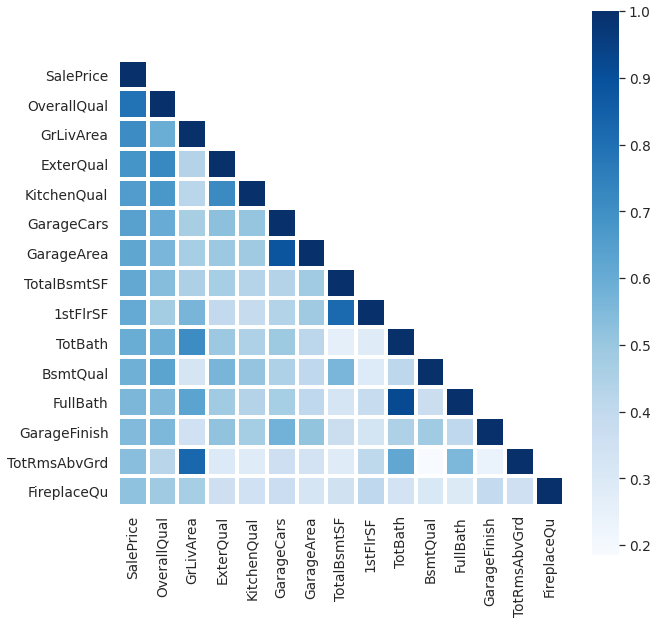

In [478]:
# Correlation Heatmap
n = 15
params = Train.corr().nlargest(n, 'SalePrice').index
coefs = np.corrcoef(Train[params].values.T)
mask = np.zeros_like(coefs)
mask[np.triu_indices_from(mask, 1)] = True
with sns.axes_style('white'):
    f, ax = plt.subplots(figsize=(10, 10))
    sns.set(font_scale=1.25)
    sns.heatmap(coefs, cmap='Blues', cbar=True, annot=False, square=True, fmt='.1f', annot_kws={'size':12},
                yticklabels=params.values, xticklabels=params.values, linewidths=3, linecolor='white', mask=mask)
#     plt.title('Feature Correlation Heatmap', fontsize=30, fontdict={'horizontalalignment':'center'},
#                pad=75)
#     plt.savefig('CorrMap_10.png')

[Text(0.5, 0, 'Basement SF')]

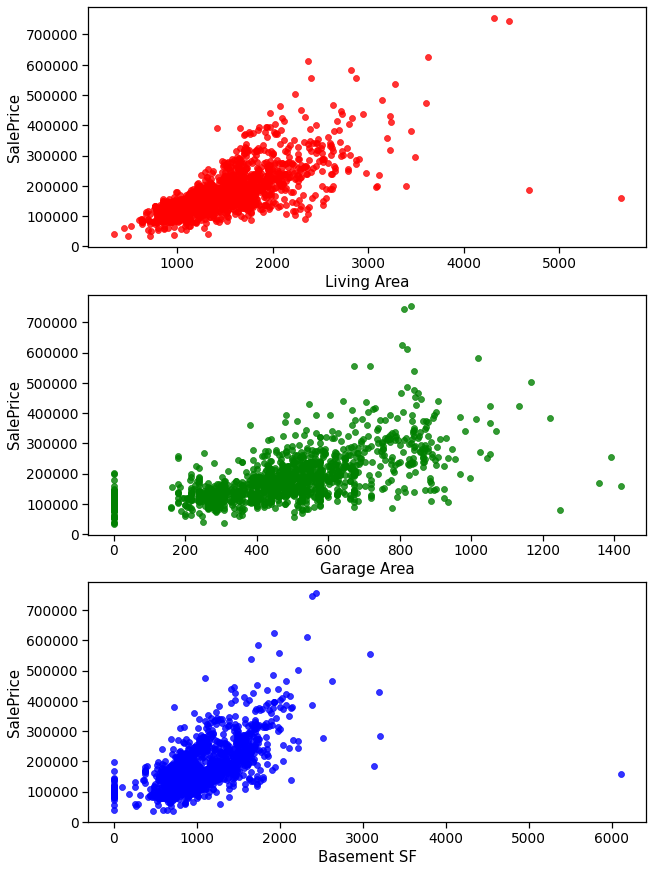

In [479]:
# Visualize
f, axs = plt.subplots(3, 1, figsize=(10, 15))
sns.scatterplot('GrLivArea', 'SalePrice', data=Train, ax=axs[0], edgecolor=None,
                color='red', alpha=0.8).set(xlabel='Living Area')
sns.scatterplot('GarageArea', 'SalePrice', data=Train, ax=axs[1], edgecolor=None,
                color='green', alpha=0.8).set(xlabel='Garage Area')
sns.scatterplot('TotalBsmtSF', 'SalePrice', data=Train, ax=axs[2], edgecolor=None,
                color='blue', alpha=0.8).set(xlabel='Basement SF')

In [480]:
# Drop Outliers
Train.sort_values(by='GrLivArea', ascending=False)[:2]
Train.drop([1298, 523], axis=0, inplace=True)

In [481]:
Train.sort_values(by='TotalBsmtSF', ascending=False)[:1]
Train.drop([332], axis=0, inplace=True)

# Qualitative Features

In [482]:
# View Qualitative Features
qual_features = Train.dtypes[Train.dtypes == 'object'].index
print(', '.join(str(p) for p in qual_features)) 

MSSubClass, MSZoning, Alley, LandContour, LotConfig, Neighborhood, Condition1, BldgType, HouseStyle, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, Foundation, Heating, CentralAir, Electrical, GarageType, GarageYrBlt, Fence, MiscFeature, MoSold, YrSold, SaleType, SaleCondition, HasBsmt, HasGarage


In [483]:
# Order Feature Attributes by Mean Sale Price
order_overallqual = Train.groupby('OverallQual')['SalePrice'].mean().sort_values(ascending=False).index
order_housestyle = Train.groupby('HouseStyle')['SalePrice'].mean().sort_values(ascending=False).index
order_mssubclass = Train.groupby('MSSubClass')['SalePrice'].mean().sort_values(ascending=False).index
order_mszoning = Train.groupby('MSZoning')['SalePrice'].mean().sort_values(ascending=False).index
order_neighborhood = Train.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=False).index
order_garagetype = Train.groupby('GarageType')['SalePrice'].mean().sort_values(ascending=False).index
order_yearbuilt = Train.groupby('YearBuilt')['SalePrice'].mean().sort_values(ascending=True).index

[Text(0.5, 0, 'Sale Price')]

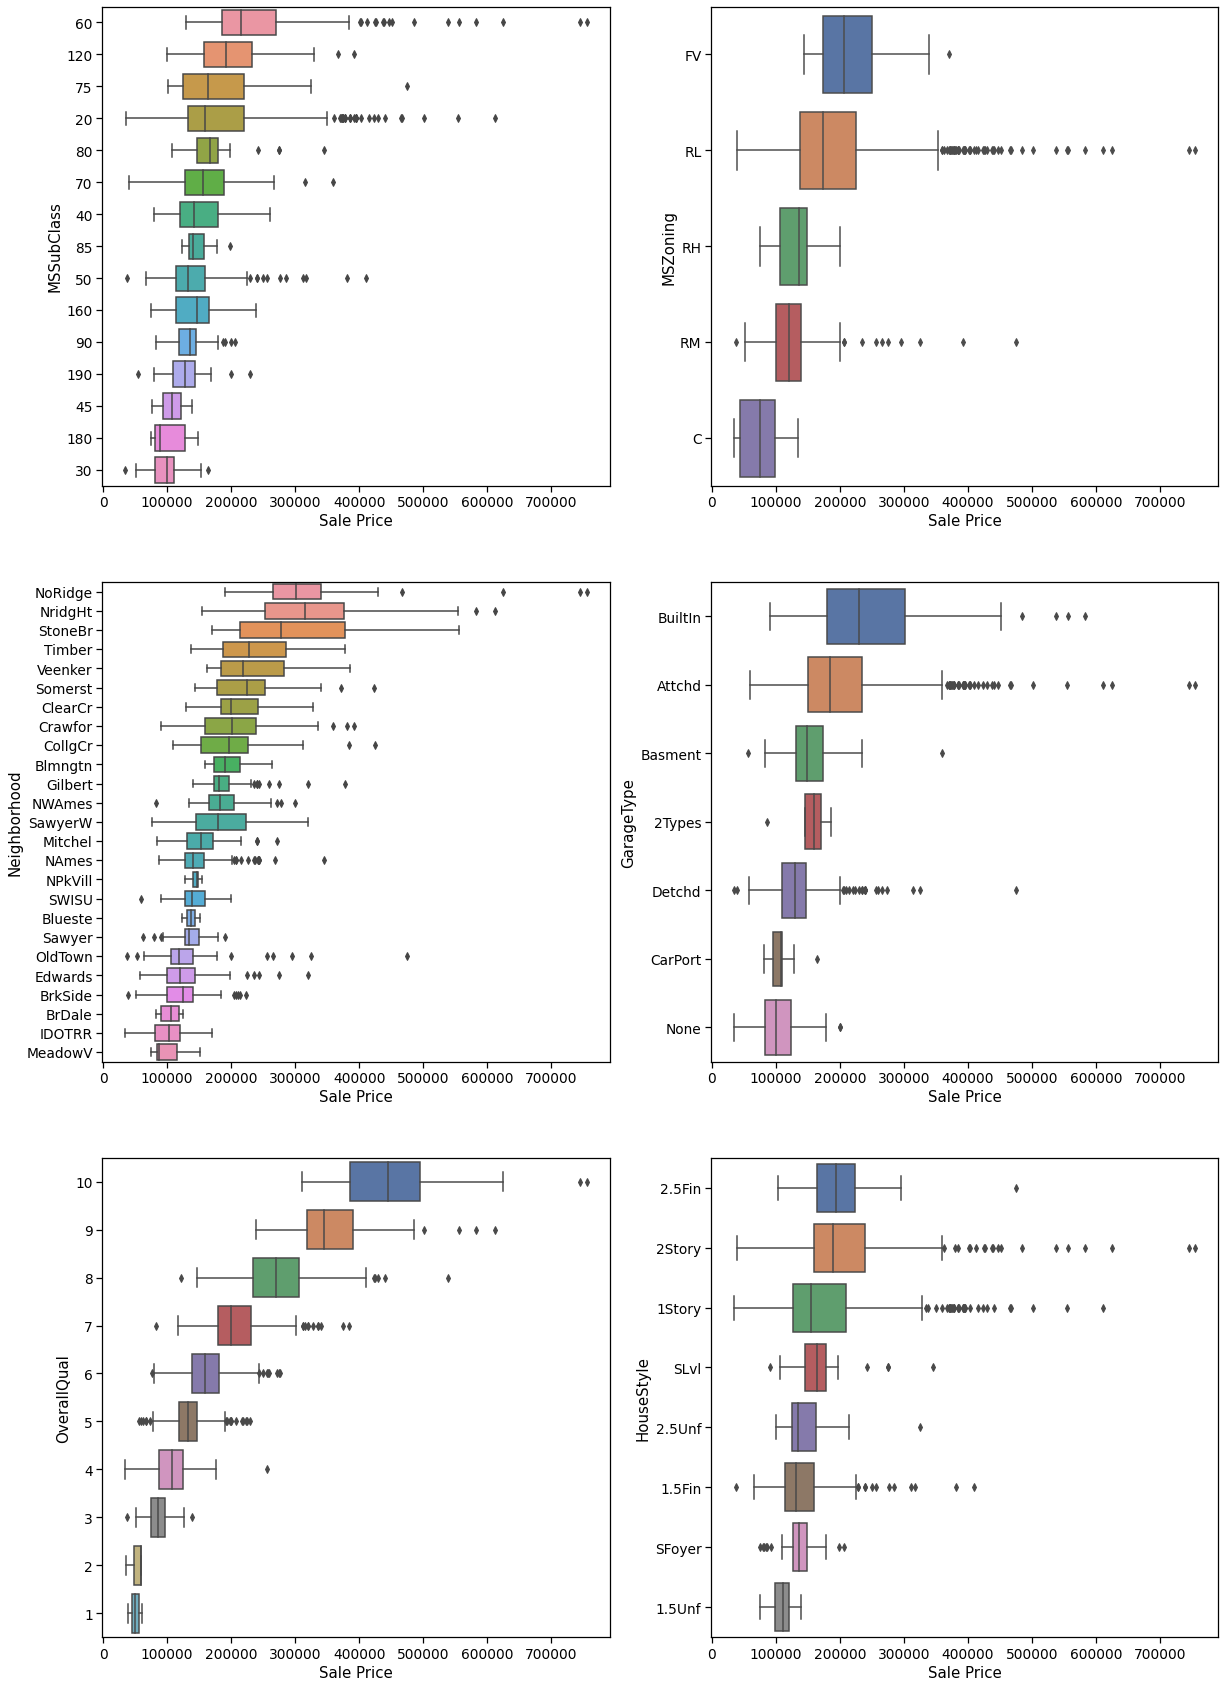

In [484]:
f, axs = plt.subplots(3, 2, figsize=(20, 30))

sns.boxplot('SalePrice', 'OverallQual', data=Train, orient='h', 
            order=order_overallqual, ax=axs[2, 0]).set(xlabel='Sale Price')
sns.boxplot('SalePrice', 'HouseStyle', data=Train, orient='h', 
            order=order_housestyle, ax=axs[2, 1]).set(xlabel='Sale Price')
sns.boxplot('SalePrice', 'MSSubClass', data=Train, orient='h', 
            order=order_mssubclass, ax=axs[0, 0]).set(xlabel='Sale Price')
sns.boxplot('SalePrice', 'MSZoning', data=Train, orient='h', 
            order=order_mszoning, ax=axs[0, 1]).set(xlabel='Sale Price')
sns.boxplot('SalePrice', 'Neighborhood', data=Train, orient='h', 
            order=order_neighborhood, ax=axs[1, 0]).set(xlabel='Sale Price')
sns.boxplot('SalePrice', 'GarageType', data=Train, orient='h', 
            order=order_garagetype, ax=axs[1, 1]).set(xlabel='Sale Price')
# plt.savefig('Qual_Feat_Boxplots.png')

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text major ticklabel objects>)

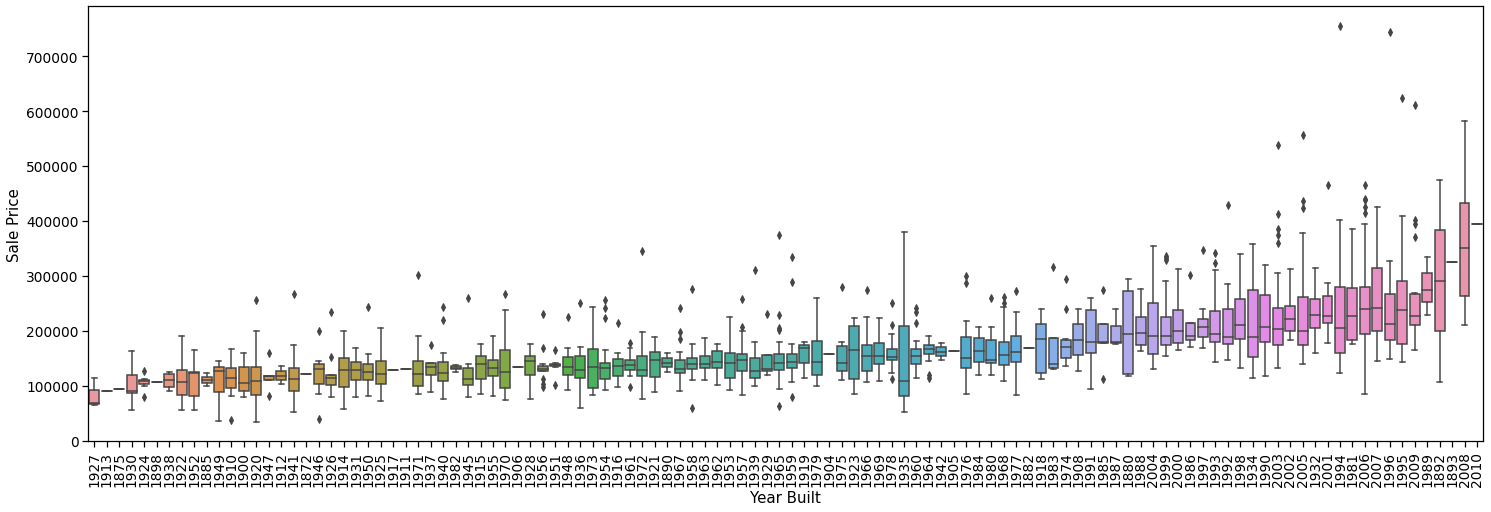

In [485]:
plt.subplots(figsize=(25, 8))
sns.boxplot('YearBuilt', 'SalePrice', data=Train, order=order_yearbuilt)
plt.xlabel('Year Built')
plt.ylabel('Sale Price')
plt.xticks(rotation=90)

# Normalize Data
### 1. Response Variable

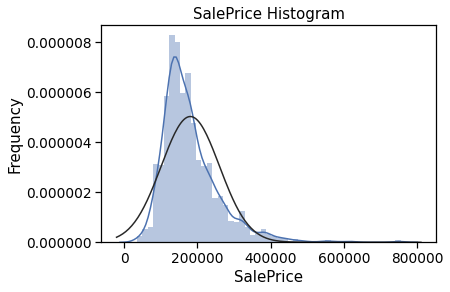

In [486]:
# SalePrice Distribution
sns.distplot(Train['SalePrice'], fit=norm)
plt.title('SalePrice Histogram')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='y')

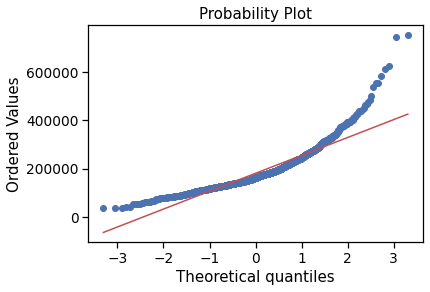

In [487]:
# SalePrice QQ-Plot
plt.figure()
stats.probplot(Train['SalePrice'], plot=plt)
plt.show()

In [488]:
# Log Transform to Correct Right-Skew
Train['SalePrice'] = np.log1p(Train['SalePrice'])

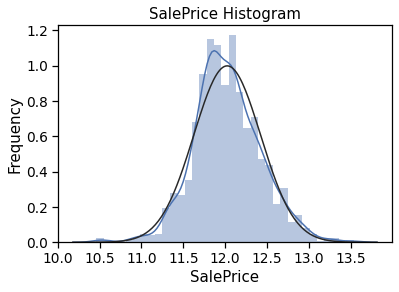

In [489]:
# Corrected SalePrice Distribution
sns.distplot(Train['SalePrice'], fit=norm)
plt.title('SalePrice Histogram')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='y')

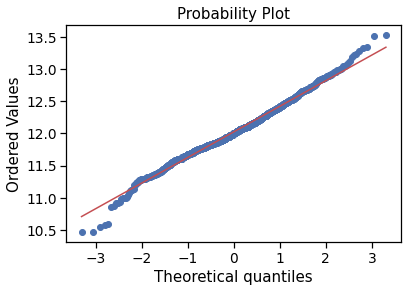

In [490]:
# SalePrice QQ-Plot
plt.figure()
stats.probplot(Train['SalePrice'], plot=plt)
plt.show()

### 2. Explanatory Variables

In [491]:
# View Quantitative Features
quant_features = Train.dtypes[Train.dtypes != 'object'].index
print(', '.join(str(p) for p in quant_features)) 

LotFrontage, LotArea, LotShape, LandSlope, OverallQual, OverallCond, MasVnrArea, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, HeatingQC, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, MiscVal, HouseAge, TotBath, SalePrice


In [492]:
# Test for Skew
quant_skew = pd.DataFrame({'Skew':(Train[quant_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False))})
quant_skew.head(10)

,Skew
MiscVal,24.426546
LotArea,12.556723
3SsnPorch,10.282886
LowQualFinSF,8.992490
KitchenAbvGr,4.478508
BsmtFinSF2,4.269914
ScreenPorch,4.113045
BsmtHalfBath,4.094248
BsmtFinType2,3.295257
EnclosedPorch,3.082631


In [493]:
# Adjust High Skew Using Box Cox Transformation
high_skew = quant_skew[quant_skew['Skew'].abs() > 1]
skewed_features = high_skew.index
lam = 0.15
for feature in skewed_features:
    Train[feature] = boxcox1p(Train[feature], lam)

In [494]:
# Check Adjusted Skew
adj_skew = pd.DataFrame({'Skew':(Train[quant_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False))})
adj_skew.head(10)

,Skew
3SsnPorch,7.819389
LowQualFinSF,7.585094
MiscVal,5.499324
KitchenAbvGr,3.990907
BsmtHalfBath,3.938880
ScreenPorch,3.180245
BsmtFinSF2,2.627854
BsmtFinType2,2.164918
EnclosedPorch,2.157475
BsmtUnfSF,0.920820


### 3. Visual Check

[Text(0.5, 0, 'Basement SF')]

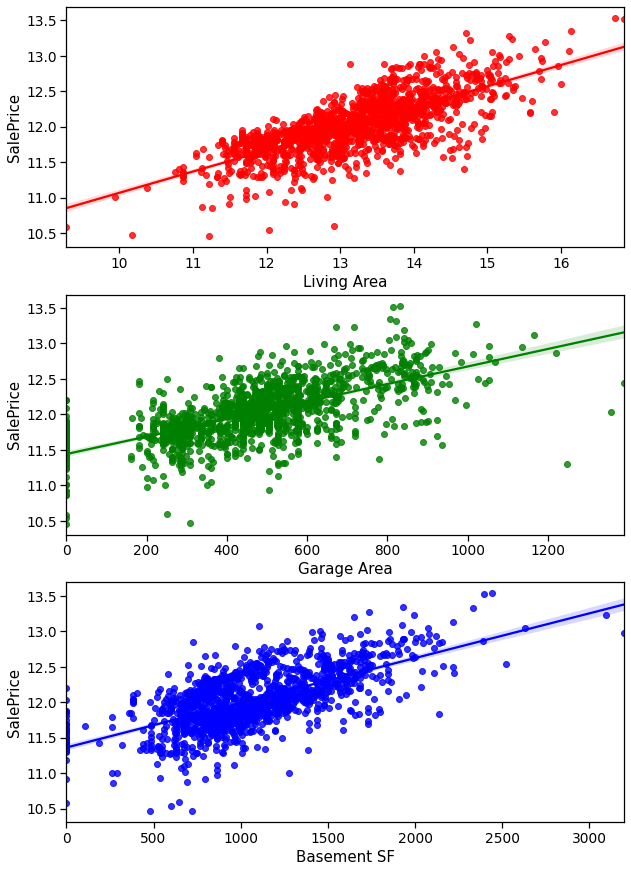

In [495]:
f, axs = plt.subplots(3, 1, figsize=(10, 15))
sns.regplot('GrLivArea', 'SalePrice', data=Train, ax=axs[0], fit_reg=True,
                color='red').set(xlabel='Living Area')
sns.regplot('GarageArea', 'SalePrice', data=Train, ax=axs[1], fit_reg=True,
                color='green').set(xlabel='Garage Area')
sns.regplot('TotalBsmtSF', 'SalePrice', data=Train, ax=axs[2], fit_reg=True,
                color='blue').set(xlabel='Basement SF')

# Modeling
### 1. Preparation

In [497]:
# Create Dummy Variables
len_Train = Train.shape[0]
len_Test = Test.shape[0]
Y_train = Train['SalePrice'].to_frame()
Train.drop('SalePrice', axis=1, inplace=True)

In [512]:
Data = pd.concat([Train, Test], axis=0)
Data.shape

(2916, 78)

In [520]:
Data = pd.get_dummies(Data)
XY_train = copy.deepcopy(Data[:len_Train])
XY_train['SalePrice'] = Y_train
XY_test = copy.deepcopy(Data[len_Train:])
print(XY_train.shape)
print(XY_test.shape)

(1457, 535)
(1459, 534)


In [524]:
# Cross-validation
num_folds = 5
def rmsle_cv(model):
    kf = KFold(num_folds, shuffle=True, random_state=42).get_n_splits(XY_train.values)
    rmse = np.sqrt(-cross_val_score(model, XY_train.values, Y_train, scoring='neg_mean_squared_error', cv=kf))
    return(rmse)